# SkyCamera Image Analysis

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import json
import collections
import functools

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches

In [5]:
import numpy as np

In [6]:
import scipy.special
import scipy.signal
import scipy.linalg
import scipy.stats

In [7]:
import fitsio as fits

## Utilities

In [8]:
def downsample(data, downsampling, summary=np.sum, allow_trim=False):
    """Downsample a 2D array.
    
    Parameters
    ----------
    data : array
        Two dimensional array of values to downsample.
    downsampling : int
        Downsampling factor to use along both dimensions. Must evenly divide the
        data dimensions when allow_trim is False.
    summary : callable
        The summary function to use that will be applied to each block of shape
        (dowsampling, downsampling) to obtain the output downsampled values.
        Must support broadcasting and an axis parameter. Useful choices are
        np.sum, np.mean, np.min, np.max, np.median, np.var but any ufunc
        should work.
    allow_trim : bool
        When False, the input dimensions (ny, nx) must both exactly divide
        the downsampling value.  Otherwise, any extra rows and columns are
        silently trimmed before apply the summary function.
        
    Returns
    -------
    array
        A two dimensional array of shape (ny // downsampling, nx // downsampling)
        where the input data shape is (ny, nx).
    """
    data = np.asarray(data)
    if data.ndim != 2:
        raise ValueError('Data must be 2 dimensional.')
    ny, nx = data.shape
    if not allow_trim and ((nx % downsampling) or (ny % downsampling)):
        raise ValueError('Data shape {0} does not evenly divide downsampling={1} and allow_trim is False.'
                         .format((ny, nx), downsampling))
    ny //= downsampling
    nx //= downsampling
    shape = (ny, nx, downsampling, downsampling)
    strides = (downsampling * data.strides[0], downsampling * data.strides[1]) + data.strides
    blocks = np.lib.stride_tricks.as_strided(
        data[:downsampling * ny, :downsampling * nx], shape=shape, strides=strides)
    return summary(blocks, axis=(2, 3))

In [9]:
downsample(np.ones((11, 10)), 2, allow_trim=True)

array([[4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.]])

In [232]:
def make_template(size, profile, dx=0, dy=0, oversampling=10, normalized=True):
    """Build a square template for an arbitrary profile.
    """
    xy = (np.arange(size * oversampling) - 0.5 * (size * oversampling - 1)) / oversampling
    z = profile(xy - dx, (xy - dy).reshape(-1, 1))
    T = downsample(z, oversampling, np.mean)
    if normalized:
        T /= T.sum()
    return T

Define some useful profiles:

In [11]:
def fiber_profile(x, y, r0, blur=0.1):
    r = np.sqrt(x ** 2 + y ** 2)
    return 0.5 + 0.5 * scipy.special.erf((r0 - r) / (np.sqrt(2) * blur))

In [12]:
def moffat_profile(x, y, fwhm, sx=1, sy=1, beta=3.5):
    r0 = fwhm / (2 * np.sqrt(2 ** (1 / beta) - 1))
    r = np.sqrt((x / sx) ** 2 + (y / sy) ** 2)
    return (1 + (r / r0) ** 2) ** -beta

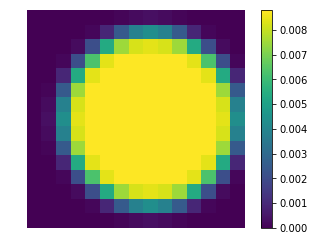

In [233]:
T = make_template(15, functools.partial(fiber_profile, r0=6, blur=0.5), dx=1)
plt.imshow(T, interpolation='none', origin='lower')
plt.colorbar()
plt.axis('off');

## Real Noise Images

In [294]:
with fits.open('noise1x1.fits') as hdus:
    noise1 = hdus[0].data
    print(noise1.shape)
    noise1, _, _ = scipy.stats.sigmaclip(noise1.reshape(-1))
    print(np.mean(noise1), np.std(noise1))

(2047, 3072)
1065.4376075673576 12.80953857267008


In [295]:
with fits.open('noise2x2.fits') as hdus:
    noise2 = hdus[0].data
    print(noise2.shape)
    noise2, _, _ = scipy.stats.sigmaclip(noise2.reshape(-1))
    print(4 * np.mean(noise2), np.sqrt(4) * np.std(noise2))

(1023, 1536)
2170.6489195162976 24.7167556482324


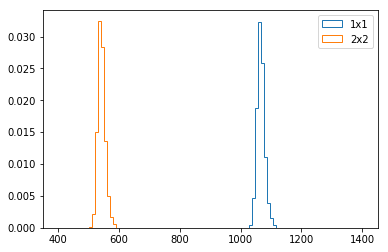

In [299]:
plt.hist(noise1, bins=np.linspace(400, 1400, 100), histtype='step', label='1x1', density=True)
plt.hist(noise2, bins=np.linspace(400, 1400, 100), histtype='step', label='2x2', density=True)
#plt.yscale('log')
plt.legend();

## Nominal Fiber Locations

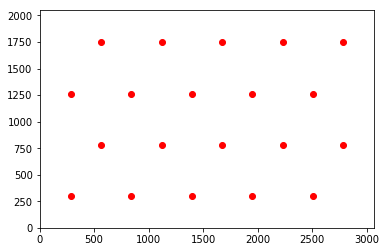

In [710]:
def get_nominal_fibers(grid=(4, 5), spacing_mm=5., fiberdiam_um=9., nxpix=3072, nypix=2048):
    x = np.arange(grid[1]) * spacing_mm
    y = np.arange(grid[0]) * spacing_mm * np.sqrt(3) / 2
    xx, yy = np.meshgrid(x, y)
    # Offset odd-numbered rows.
    xx[1::2] += 0.5 * spacing_mm
    # Center fibers on the origin.
    yy -= yy.mean()
    xx -= xx.mean()
    # Convert to pixels.
    xx /= 1e-3 * fiberdiam_um
    yy /= 1e-3 * fiberdiam_um
    xx += nxpix // 2
    yy += nypix // 2

    plt.plot(xx, yy, 'ro')
    plt.xlim(0, nxpix)
    plt.ylim(0, nypix)
    
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    fibers = collections.OrderedDict()
    for k, (x, y) in enumerate(zip(xx, yy)):
        label = 'SKY{0}'.format(k)
        fibers[label] = (int(x), int(y))
    with open('fibers.json', 'w') as f:
        json.dump(fibers, f, indent=4)
    
get_nominal_fibers()

## Simulated Images

In [787]:
def simulate(nx=3072, ny=2047, fibers='fibers.json', nphot_mean=5e4, dxy=5.,
             binning=1, blur=0.5, invgain=1.6, throughput=0.2,
             fiberdiam_um=107., pixelsize_um=9.,
             bglevel_adu=1065., bgrms_adu=13., rng=None):
    with open(fibers, 'r') as f:
        fibers = json.load(f, object_pairs_hook=collections.OrderedDict)
    # Convert fiber diameter to pixels.
    fiberdiam = fiberdiam_um / pixelsize_um
    # Generate background noise (in ADUs).
    rng = rng or np.random.RandomState()
    data = rng.normal(loc=bglevel_adu, scale=bgrms_adu, size=(ny, nx))
    # Add signals from each fiber.
    signal = np.zeros((ny, nx))
    bins = (np.arange(nx + 1), np.arange(ny + 1))
    truth = collections.OrderedDict()
    for label, (xfiber, yfiber) in fibers.items():
        # Add some random jitter.
        xfiber += rng.uniform(-0.5 * dxy, +0.5 * dxy)
        yfiber += rng.uniform(-0.5 * dxy, +0.5 * dxy)
        # Generate the number of incident photons.
        nphot_inc = rng.poisson(lam=nphot_mean)
        # Generate the number of detected photons.
        nphot_det = rng.binomial(n=nphot_inc, p=throughput)
        truth[label] = nphot_det / invgain
        # Assign photon positions w/o blur.
        r = 0.5 * fiberdiam * np.sqrt(rng.uniform(size=nphot_det))
        phi = 2 * np.pi * rng.uniform(size=nphot_det)
        x0 = xfiber + r * np.cos(phi)
        y0 = yfiber + r * np.sin(phi)
        # Apply blur.
        x = rng.normal(loc=x0, scale=blur)
        y = rng.normal(loc=y0, scale=blur)
        # Bin in pixels.
        pixels, _, _ = np.histogram2d(x, y, bins=bins)
        # Convert to ADUs and add to the final image.
        data += pixels.T / invgain
    # Downsample.
    data = downsample(data, binning)
    return data, truth

OrderedDict([('SKY0', 2442.5), ('SKY1', 2507.5), ('SKY2', 2471.875), ('SKY3', 2485.0), ('SKY4', 2441.875), ('SKY5', 2556.25), ('SKY6', 2498.125), ('SKY7', 2527.5), ('SKY8', 2523.125), ('SKY9', 2462.5), ('SKY10', 2445.625), ('SKY11', 2427.5), ('SKY12', 2550.625), ('SKY13', 2487.5), ('SKY14', 2522.5), ('SKY15', 2542.5), ('SKY16', 2481.875), ('SKY17', 2455.0), ('SKY18', 2470.0), ('SKY19', 2443.125)])


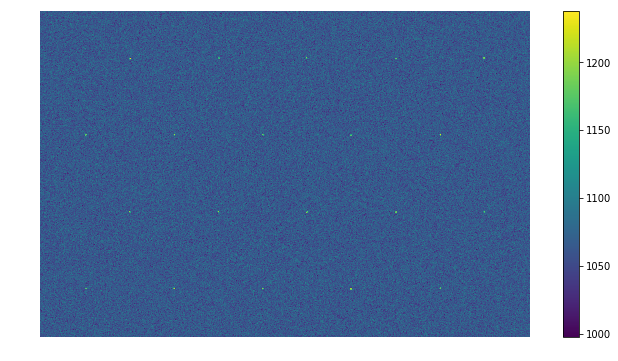

In [741]:
rng = np.random.RandomState(seed)
bright, truth = simulate(nphot_mean=1e5, rng=rng)
data, truth = simulate(nphot_mean=2e4, rng=rng)
fig = plt.figure(figsize=(12, 6))
plt.imshow(bright, interpolation='none', origin='lower')
plt.colorbar()
plt.gca().axis('off')
print(truth)

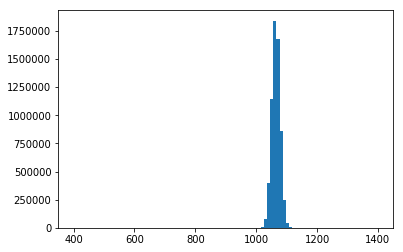

In [715]:
plt.hist(data.flatten(), bins=np.linspace(400, 1400, 100));

## Analysis Algorithm

The purpose of the analysis is to:
 - find each fiber
 - measure its signal and surrounding background level

In [771]:
class SkyCameraAnalysis(object):
    """ Initialize the Sky Camera image analysis.
    
    Parameters
    ----------
    nx : int
        Number of columns in a full frame image with no binning.
    ny : int
        Number of rows in a full frame image with no binning.
    binning : int
        Binning of the images to process. Must be in (1, 2, 3).
    fiberdiam_um : float
        Fiber diameter in microns.
    pixelsize_um : float
        Phyiscal (unbinned) pixel size in microns.
    blur_pix : float
        Focus blur of fiber tips in microns.
    margin : float
        Postage stamp cutouts are scaled to be larger than the fiber by this factor.
    search_pix : float
        Size of centroid search region to scan in units of unbinned pixels.
    search_steps : int
        Number of search grid points to use covering the search region.
    """
    def __init__(self, nx=3072, ny=2047, binning=1,
                 fiberdiam_um=107., pixelsize_um=9., blur_um=5.,
                 margin=2.0, search_pix=14, search_steps=29):
        self.ny = ny
        self.nx = nx
        self.binning = binning
        if binning not in (1, 2, 3):
            raise ValueError('Expected binning in (1, 2, 3).')
        # Convert fiber diameter and blur to pixels.
        self.fiberdiam = fiberdiam_um / pixelsize_um
        blur = blur_um / pixelsize_um
        # Calculate the stamp size to use as ssize = 2 * rsize + 1 (always odd).
        self.rsize = int(np.ceil((margin * 0.5 * self.fiberdiam + 3 * blur) / binning))
        ssize = 2 * self.rsize + 1
        # Build templates for different sub-pixel offsets.
        self.dxy = np.linspace(-0.5 * search_pix / binning,
                               +0.5 * search_pix / binning, search_steps)
        self.T = np.empty((search_steps, search_steps, ssize, ssize))
        for j, dy in enumerate(self.dxy):
            for i, dx in enumerate(self.dxy):
                self.T[j, i] = make_template(
                    ssize, 0.5 * self.fiberdiam / binning, dx=dx, dy=dy, blur=blur / binning,
                    oversampling=10 * binning)
        # Calculate the fiber area in binned pixels, for normalizing SNR calculations.
        self.fiber_area = np.pi * (0.5 * self.fiberdiam / binning) ** 2
        # Check precision of template areas.
        assert np.allclose(self.T.sum(axis=(2, 3)), self.fiber_area, rtol=5e-4)
        # Normalize each template.
        self.T /= self.T.sum(axis=(2, 3), keepdims=True)
        # We do not have any fiber location info yet.
        self.fibers = None
     
    def validate(self, data):
        """
        """
        data = np.asarray(data)
        ny, nx = data.shape
        if ny != self.ny // self.binning or nx != self.nx // self.binning:
            raise ValueError('Input data has unexpected shape: {data.shape}.')
        return data
    
    def find_fiber_locations(self, data, nfibers=18, savename=None):
        """Find fiber locations as the brightest points with the expected shape.
        
        The algorithm convolves the data with a filter matched to the fiber size
        and will always return the requested number of locations subject to the
        constraints that no two fibers are within a stamp size of each other
        and no fiber is within rsize of the image edge.
        
        To get reliable results, all fibers should have sufficiently bright images.
        The located centroids should then be accurate to ~1 binned pixel.
        
        Parameters
        ----------
        data : array
            2D array of image data with shape (ny, nx).
        nfibers : int
            The number of fibers to locate.
        savename : string or None
            Save the results to the specified filename in the json format expected
            by :meth:`load_fiber_locations` when not None. Note that labels
            will be assigned in order of decreasing brightness and will not
            be matched to petal locations.
            
        Returns
        -------
        tuple
            Tuple (xfiber, yfiber) of nfiber centroids in unbinned pixel coordinates.
        """
        data = self.validate(data)
        ny, nx = data.shape
        # Use a template for a fiber ~centered in the stamp.
        nby2 = len(self.T) // 2
        T0 = self.T[nby2, nby2]
        # Convolve the image with this template.
        filtered = scipy.signal.convolve(data, T0, mode='valid')
        nyf, nxf = filtered.shape
        assert ny == nyf + 2 * self.rsize and nx == nxf + 2 * self.rsize
        clear_value = np.min(filtered)
        # Locate fibers in decreasing order of template correlation.
        xfiber, yfiber = [], []
        while len(xfiber) < nfibers:
            # Find the largest (filtered) pixel value.
            iy, ix = np.unravel_index(np.argmax(filtered), (nyf, nxf))
            xfiber.append(self.binning * (ix + self.rsize))
            yfiber.append(self.binning * (iy + self.rsize))
            # Clear pixels in the stamp centered on this pixel.
            xlo, ylo = max(0, ix - self.rsize), max(0, iy - self.rsize)
            xhi, yhi = min(nxf, ix + self.rsize + 1), min(nyf, iy + self.rsize + 1)
            filtered[ylo:yhi, xlo:xhi] = clear_value
        if savename is not None:
            labels = [f'SKY{k}' for k in range(nfibers)]
            fibers = collections.OrderedDict()
            for k, label in enumerate(labels):
                fibers[label] = int(xfiber[k]), int(yfiber[k])
            with open(savename, 'w') as f:
                json.dump(fibers, f, indent=4)
        return xfiber, yfiber
    
    def load_fiber_locations(self, name='fibers.json'):
        """Load fiber locations from a json file.
        
        All fiber locations must be inset at least rsize from the image
        borders and at least 2 * rsize + 1 pixels away from other locations.
        
        This method must be called before :meth:`get_fiber_fluxes`.
        
        Parameters
        ----------
        name : str
            Name of the json file to load.
        """
        with open(name, 'r') as f:
            self.fibers = json.load(f, object_pairs_hook=collections.OrderedDict)
        # Build a mask to select background pixels for noise measurement.
        self.mask = np.ones((self.ny // self.binning, self.nx // self.binning), bool)
        for (x, y) in self.fibers.values():
            x //= self.binning
            y //= self.binning
            xlo, ylo = x  - self.rsize, y - self.rsize
            xhi, yhi = x + self.rsize + 1, y + self.rsize + 1
            self.mask[ylo:yhi, xlo:xhi] = False
        if np.count_nonzero(~self.mask) != len(self.fibers) * (2 * self.rsize + 1) ** 2:
            raise ValueError('Fiber location constraints are violated.')
        
    def get_fiber_fluxes(self, data):
        """Estimate fiber fluxes and SNR values.
        
        Scans the search window for each fiber to identify the maximum
        likelihood fiber centroid position and calcualtes the corresponding
        background level and integrated fiber flux (using linear least squares).
        
        The signal-to-noise ratios are calculated assuming a noise of
        pixel_rms * sqrt(fiber_area) where pixel_rms is the sigma-clipped
        standard deviation of pixel values outside each fiber stamp.
        
        Uses the fiber locations from the most recent call to
        :meth:`load_fiber_locations`.
        
        Parameters
        ----------
        data : array
            2D array of image data with shape (ny, nx).

        Returns
        -------
        dict
            A dictionary of per-fiber results using the fiber labels as keys.
            Each entry provides (xfit, yfit, bgmean, fiber_flux, snr, stamp) where
            (xfit, yfit) are in units of unbinned pixels, (bgmean, fiber_flux)
            are in units of ADUs, SNR is as described above, and stamp is a copy
            of the postage stamp used for each fiber.
        """
        if self.fibers is None:
            raise RuntimeError('No fiber locations specified yet.')
        data = self.validate(data)
        # Estimate total noise over a fiber.
        noise_pixels, _, _ = scipy.stats.sigmaclip(data[self.mask])
        fiber_noise = np.sqrt(self.fiber_area * np.var(noise_pixels))
        # Assemble all fiber stamps into a single data array D.
        ssize = 2 * self.rsize + 1
        nfibers = len(self.fibers)
        D = np.empty((ssize ** 2, nfibers))
        stamps = []
        for k, (label, (x, y)) in enumerate(self.fibers.items()):
            # Extract the stamp centered on (x, y)
            ix = x // self.binning
            iy = y // self.binning
            stamp = data[iy - self.rsize:iy + self.rsize + 1,
                         ix - self.rsize:ix + self.rsize + 1].copy()
            D[:, k] = stamp.reshape(-1)
            stamps.append(stamp)
        # Loop over centroid hypotheses.
        nsteps = len(self.T)
        params = np.empty((nsteps, nsteps, 2, nfibers))
        scores = np.empty((nsteps, nsteps, nfibers))
        for j in range(nsteps):
            for i in range(nsteps):
                A = np.stack((np.ones(stamp.size), self.T[j, i].reshape(-1)), axis=1)
                # Solve the linear least-squares problem to find the mean noise and fiber flux
                # for this centroid hypothesis, simultaneously for all fibers.
                params[j, i], scores[j, i], _, _ = scipy.linalg.lstsq(A, D)
        # Find the maximum likelihood centroid for each stamp.
        idx = np.argmin(scores.reshape(nsteps ** 2, nfibers), axis=0)
        jbest, ibest = np.unravel_index(idx, (nsteps, nsteps))
        # Build the results.
        results = collections.OrderedDict()
        for k, (label, (x, y)) in enumerate(self.fibers.items()):
            # Convert grid indices to unbinned pixel coordinates.
            xfit = x + self.dxy[ibest[k]] * self.binning
            yfit = y + self.dxy[jbest[k]] * self.binning
            bgmean, fiber_flux = params[jbest[k], ibest[k], :, k]
            snr = fiber_flux / fiber_noise
            results[label] = (xfit, yfit, bgmean, fiber_flux, snr, stamps[k])
        # Save the results for plot_sky_camera.
        self.results = results
        return results

In [515]:
class Axes(object):
    
    def __init__(self, n, size=4, pad=0.02):
        rows = int(np.floor(np.sqrt(n)))
        cols = int(np.ceil(n / rows))
        assert rows * cols >= n
        width = cols * size + (cols - 1) * pad
        height = rows * size + (rows - 1) * pad
        self.fig, axes = plt.subplots(rows, cols, figsize=(width, height))
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=pad, hspace=pad)
        self.axes = axes.flatten()
        self.n = n
        for ax in self.axes:
            ax.axis('off')

In [765]:
def plot_sky_camera(SCA, size=4, pad=0.02, labels=True, params=True):
    if SCA.fibers is None or SCA.results is None:
        raise RuntimeError('No results available to plot.')
    nfibers = len(SCA.fibers)
    rows = int(np.floor(np.sqrt(nfibers)))
    cols = int(np.ceil(nfibers / rows))
    width = cols * size + (cols - 1) * pad
    height = rows * size + (rows - 1) * pad
    fig, axes = plt.subplots(rows, cols, figsize=(width, height), squeeze=False)
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=pad, hspace=pad)
    results = iter(SCA.results.items())
    fibers = iter(SCA.fibers.values())
    # Use the same colorscale for all stamps.
    allpixels = np.concatenate([result[-1] for result in SCA.results.values()], axis=1).flatten()
    vmin, vmax = np.percentile(allpixels, (1, 99))
    for j in range(rows):
        for i in range(cols):
            ax = axes[j, i]
            label, (xfit, yfit, bgmean, fiber_flux, snr, stamp) = next(results)
            ix, iy = next(fibers)
            ax.imshow(stamp, interpolation='none', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
            ax.axis('off')
            cx = (xfit - ix) / SCA.binning + SCA.rsize
            cy = (yfit - iy) / SCA.binning + SCA.rsize
            cr = 0.5 * SCA.fiberdiam / SCA.binning
            circle = matplotlib.patches.Circle(
                [cx, cy], cr, lw=2, ec='r', fc='none', alpha=0.5)
            dxy = SCA.dxy + SCA.rsize
            xgrid, ygrid = np.meshgrid(dxy, dxy)
            ax.plot(xgrid[0], ygrid[0], 'r.', ms=1)
            ax.plot(xgrid[-1], ygrid[-1], 'r.', ms=1)
            ax.plot(xgrid[:, 0], ygrid[:, 0], 'r.', ms=1)
            ax.plot(xgrid[:, -1], ygrid[:, -1], 'r.', ms=1)
            ax.plot(cx, cy, 'r+')
            ax.add_artist(circle)
            kwargs = dict(verticalalignment='center', horizontalalignment='center',
                          transform=ax.transAxes, color='w', fontweight='bold')
            if labels:
                ax.text(0.5, 0.95, label, fontsize=16, **kwargs)
            if params:
                params = '{0:.1f} ADU SNR {1:.1f}'.format(fiber_flux, snr)
                ax.text(0.5, 0.05, params, fontsize=14, **kwargs)

In [772]:
SCA1 = SkyCameraAnalysis(binning=1)
SCA1.load_fiber_locations()

In [776]:
SCA2 = SkyCameraAnalysis(binning=2)
SCA2.load_fiber_locations()

In [778]:
SCA3 = SkyCameraAnalysis(binning=3)
SCA3.load_fiber_locations()

In [720]:
SCA1.find_fiber_locations(bright, nfibers=20, savename='found.json');

In [783]:
%time R1 = SCA1.get_fiber_fluxes(downsample(data, 1));

CPU times: user 2.24 s, sys: 36.8 ms, total: 2.28 s
Wall time: 386 ms


In [784]:
%time R2 = SCA2.get_fiber_fluxes(downsample(data, 2));

CPU times: user 1.16 s, sys: 67.5 ms, total: 1.23 s
Wall time: 257 ms


In [785]:
%time R3 = SCA3.get_fiber_fluxes(downsample(data, 3));

CPU times: user 954 ms, sys: 33.1 ms, total: 987 ms
Wall time: 202 ms


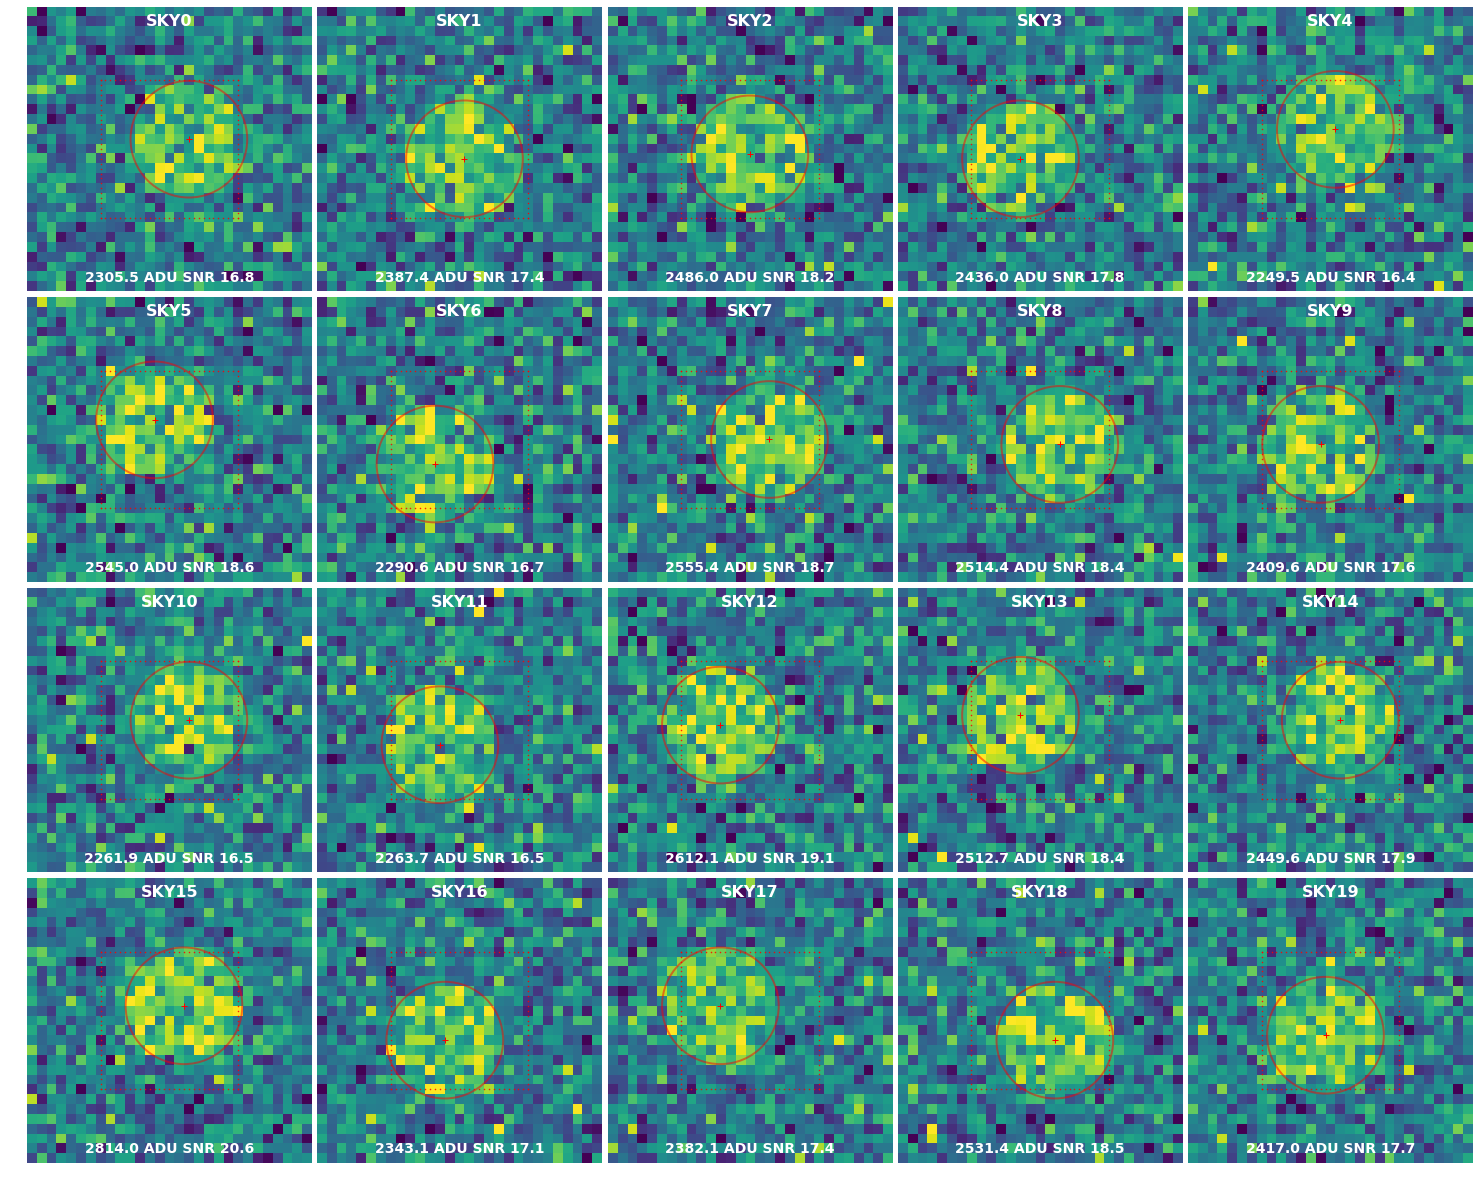

In [774]:
plot_sky_camera(SCA1)

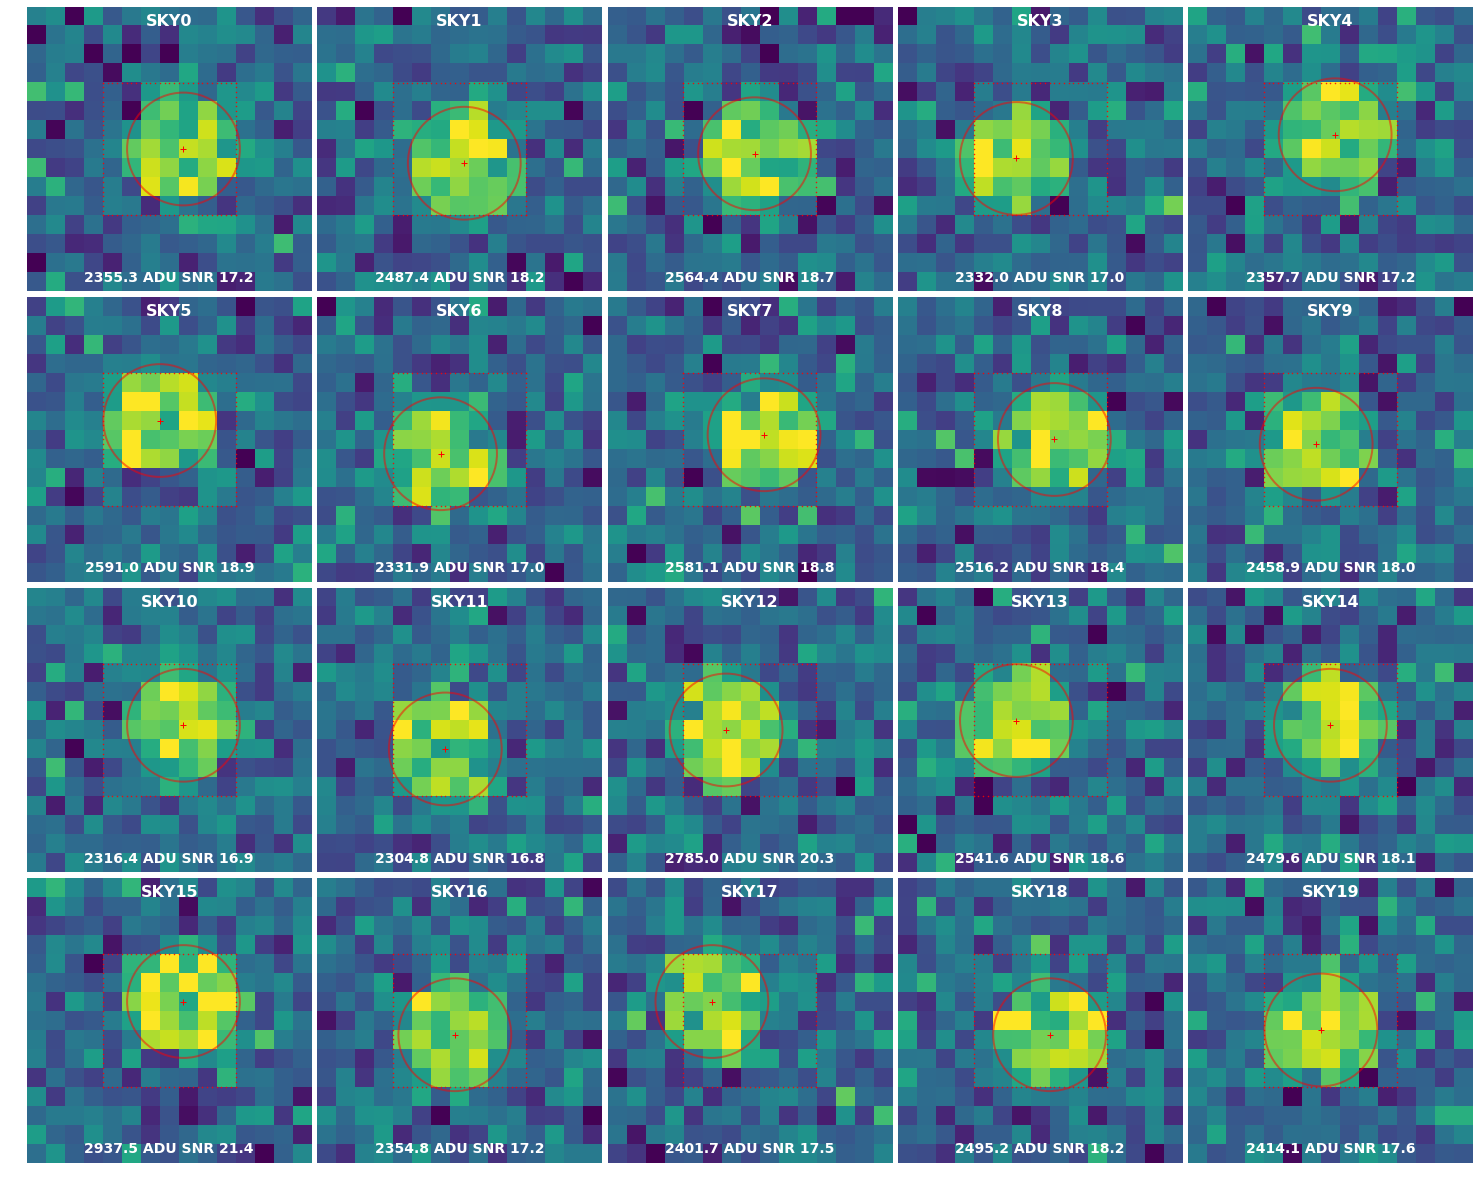

In [780]:
plot_sky_camera(SCA2)

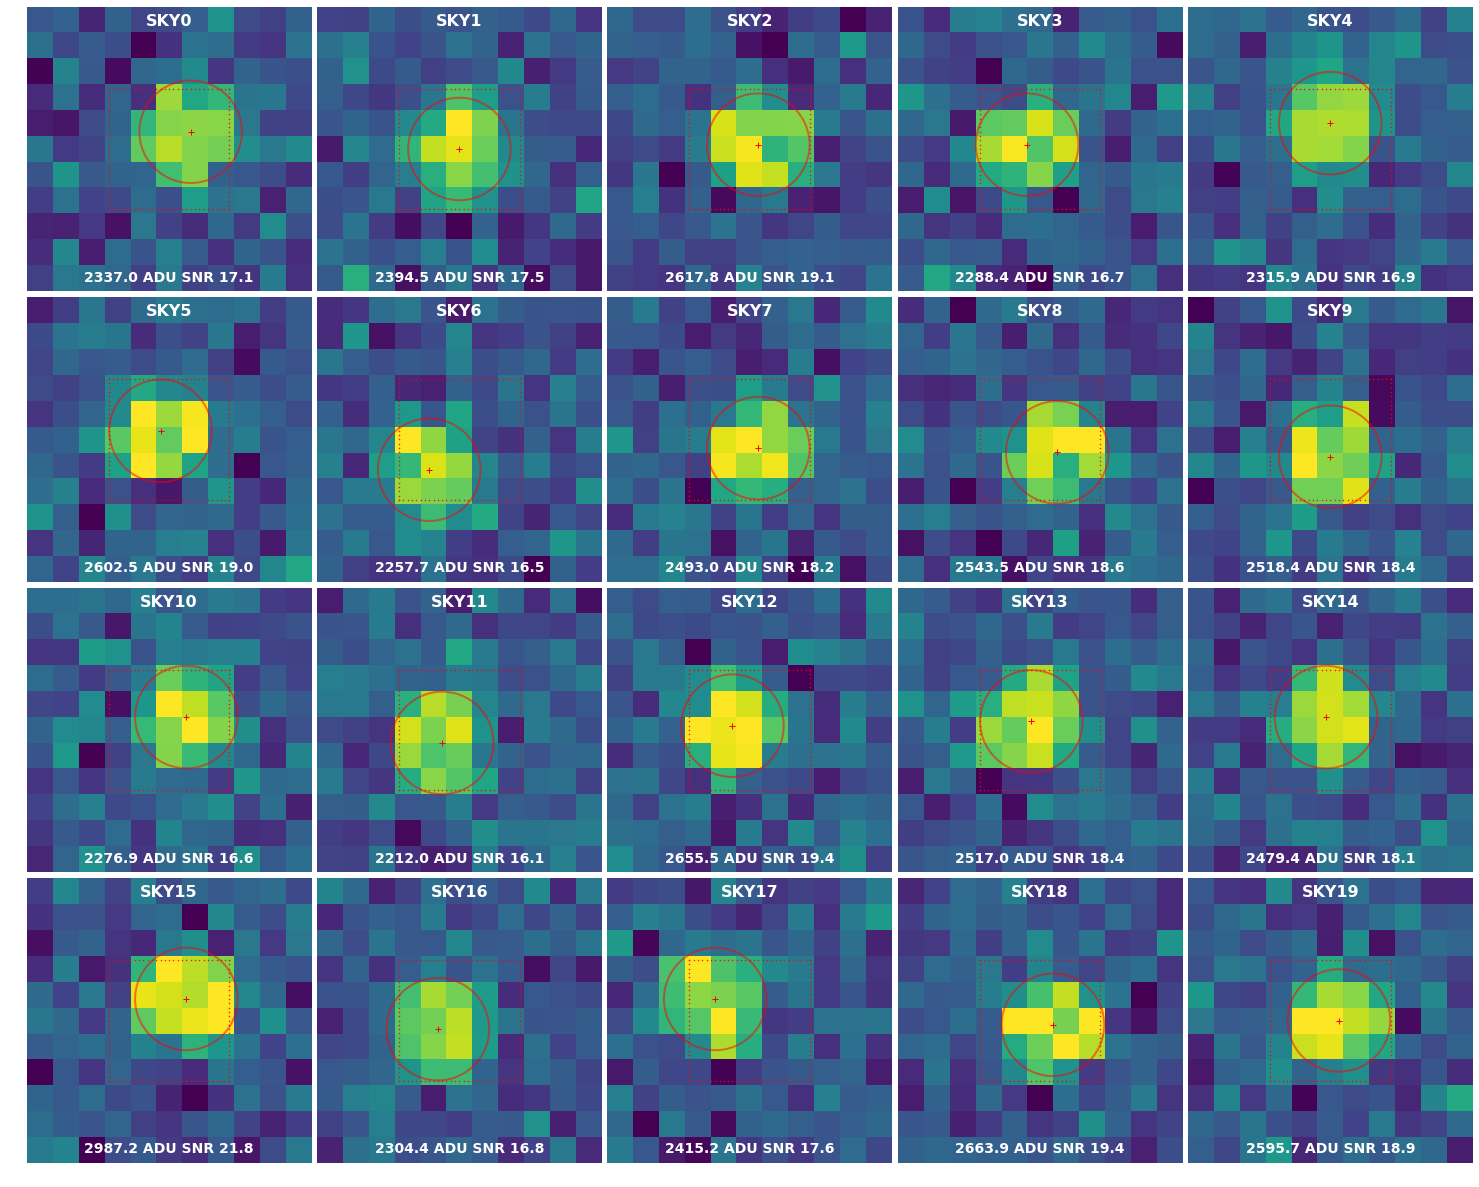

In [786]:
plot_sky_camera(SCA3)

## Validation Study

In [814]:
def validation_study(binning=2, nphot_mean=2e4, thru=0.2, invgain=1.6, ntrial=50, seed=123):
    rng = np.random.RandomState(seed)
    SCA = SkyCameraAnalysis(binning=binning)
    SCA.load_fiber_locations()
    truths, fluxes = [], []
    for i in range(ntrial):
        data, truth = simulate(binning=binning, nphot_mean=nphot_mean, throughput=thru, invgain=invgain, rng=rng)
        truths.extend([flux for flux in truth.values()])
        results = SCA.get_fiber_fluxes(data)
        fluxes.extend([result[3] for result in SCA.results.values()])
    truths = np.array(truths, float)
    fluxes = np.array(fluxes, float)
    dflux1 = fluxes - truths
    plt.hist(dflux1)
    plt.xlabel('Fit - True')
    plt.show()
    dflux2 = truths - nphot_mean * thru / invgain
    plt.hist(dflux2)
    plt.xlabel('True - Mean')
    plt.show()

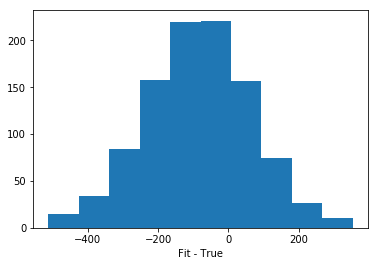

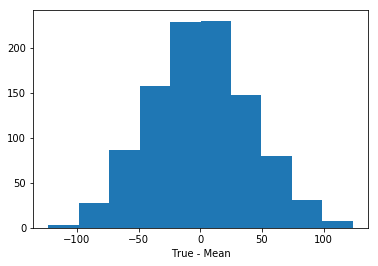

CPU times: user 4min 9s, sys: 12.5 s, total: 4min 22s
Wall time: 1min 55s


In [815]:
%time validation_study(binning=1)

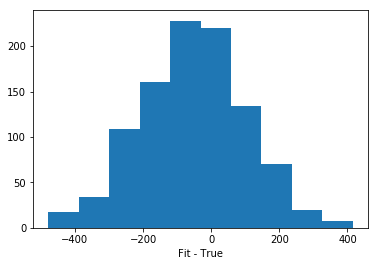

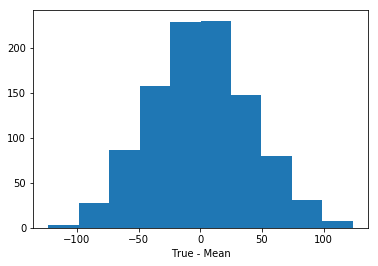

CPU times: user 3min 13s, sys: 14.1 s, total: 3min 27s
Wall time: 1min 50s


In [816]:
%time validation_study(binning=2)

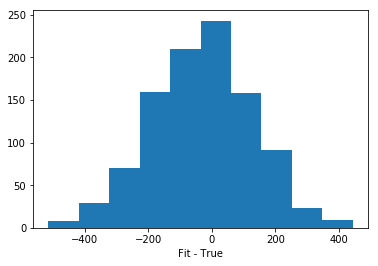

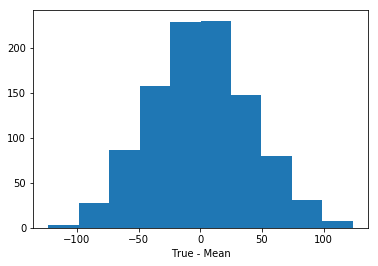

CPU times: user 2min 58s, sys: 13.2 s, total: 3min 11s
Wall time: 1min 46s


In [817]:
%time validation_study(binning=3)

## Load a CI image from a PlateMaker Sequence

In [561]:
images = {}
with fits.FITS('/Data/CI/20190524/00013116/guide-00013116.fits.fz') as hdus:
    for camera in ('CIN', 'CIE', 'CIS', 'CIW', 'CIC'):
        images[camera] = hdus[camera][0, :, :][0]

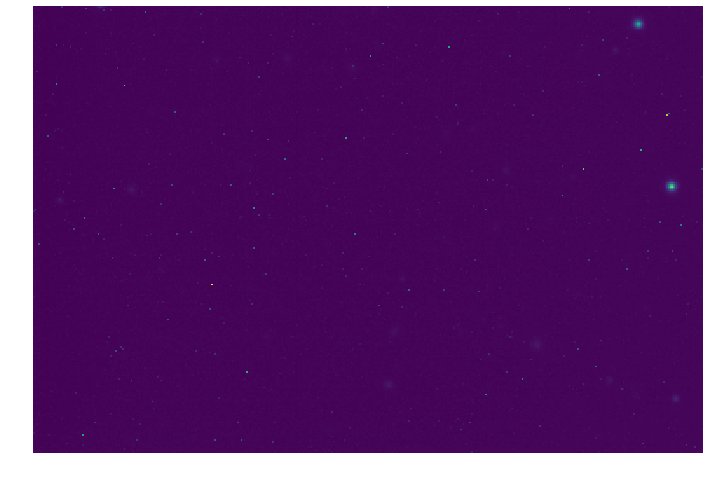

In [681]:
fig = plt.figure(figsize=(12, 9))
plt.imshow(np.log(downsample(images['CIC'], 8)), origin='lower')
plt.gca().axis('off');

## Pixel Defects

In [328]:
class Convolution(object):
    """Convolution of a source and kernel.
    
    Changes to :attr:`source` using :meth:`set_source` will automatically
    update :attr:`convolved`.
    
    The convolution uses the `same` mode.
    """
    def __init__(self, source, kernel):
        ksize = len(kernel)
        if kernel.shape != (ksize, ksize) or ksize % 2 != 1:
            raise ValueError('Kernel must be 2D and square with odd size.')
        self.kernel = np.asarray(kernel)
        self.source = np.asarray(source)
        self.convolved = scipy.signal.convolve(self.source, self.kernel, mode='same')

    def set_source(self, yslice, xslice, value):
        if not isinstance(yslice, slice):
            yslice = slice(yslice, yslice + 1)
        if not isinstance(xslice, slice):
            xslice = slice(xslice, xslice + 1)
        ny, nx = self.source.shape
        h = len(self.kernel) // 2
        self.source[yslice,  xslice] = value
        # Calculate the region of the convolution affected by this change.
        xloc = max(0, xslice.start - h)
        yloc = max(0, yslice.start - h)
        xhic = min(nx, xslice.stop + h)
        yhic = min(ny, yslice.stop + h)
        conv_slice = (slice(yloc, yhic), slice(xloc, xhic))
        # Calculate the region of the source that that contributes to the change.
        xlos = max(0, xloc - h)
        ylos = max(0, yloc - h)
        xhis = min(nx, xhic + h)
        yhis = min(ny, yhic + h)
        assert xlos <= xloc and ylos <= yloc and xhis >= xhic and yhis >= yhic        
        # Reconvolve the changed region.
        reconv = scipy.signal.convolve(
            self.source[ylos:yhis, xlos:xhis], self.kernel, mode='same')
        # Copy the changed region into the full convolution.
        x1 = xloc - xlos
        y1 = yloc - ylos
        x2 = x1 + xhic - xloc
        y2 = y1 + yhic - yloc
        self.convolved[conv_slice] = reconv[y1:y2, x1:x2]
        return conv_slice

In [384]:
class Convolutions(object):
    """Convolution of one or more sources with the same kernel.
    
    Changes to :attr:`source` using :meth:`set_source` will automatically
    update :attr:`convolved`.
    
    The convolution uses the `same` mode.
    """
    def __init__(self, sources, kernel):
        ksize = len(kernel)
        if kernel.shape != (ksize, ksize) or ksize % 2 != 1:
            raise ValueError('Kernel must be 2D and square with odd size.')
        self.kernel = np.asarray(kernel)
        ny, nx = sources[0].shape
        for source in sources[1:]:
            if source.shape != (ny, nx):
                raise ValueError('All sources must have the same shape.')
        self.sources = [np.asarray(source) for source in sources]
        self.convolved = [
            scipy.signal.convolve(source, kernel, mode='same')
            for source in sources]

    def set_source(self, yslice, xslice, value):
        if not isinstance(yslice, slice):
            yslice = slice(yslice, yslice + 1)
        if not isinstance(xslice, slice):
            xslice = slice(xslice, xslice + 1)
        ny, nx = self.sources[0].shape
        h = len(self.kernel) // 2
        # Calculate the region of the convolution affected by this change.
        xloc = max(0, xslice.start - h)
        yloc = max(0, yslice.start - h)
        xhic = min(nx, xslice.stop + h)
        yhic = min(ny, yslice.stop + h)
        conv_slice = (slice(yloc, yhic), slice(xloc, xhic))
        # Calculate the region of the source that that contributes to the change.
        xlos = max(0, xloc - h)
        ylos = max(0, yloc - h)
        xhis = min(nx, xhic + h)
        yhis = min(ny, yhic + h)
        assert xlos <= xloc and ylos <= yloc and xhis >= xhic and yhis >= yhic
        # Calculate the slice of the reconvolved output to use.
        x1 = xloc - xlos
        y1 = yloc - ylos
        x2 = x1 + xhic - xloc
        y2 = y1 + yhic - yloc
        for source, convolved in zip(self.sources, self.convolved):
            source[yslice, xslice] = value
            # Reconvolve the changed region.
            reconv = scipy.signal.convolve(
                source[ylos:yhis, xlos:xhis], self.kernel, mode='same')
            # Copy the changed region into the full convolution.
            convolved[conv_slice] = reconv[y1:y2, x1:x2]
        return conv_slice

In [378]:
def test_conv(nx=12, ny=9, ksize=5):
    source = np.arange(nx * ny).reshape(ny, nx)
    kernel = np.arange(ksize ** 2).reshape(ksize, ksize)
    #C = Convolution(source, kernel)
    C = Convolutions([source], kernel)
    k = nx * ny
    for x1 in range(0, nx - 1):
        for x2 in range(x1 + 1, nx):
            for y1 in range(0, ny - 1):
                for y2 in range(y1 + 1, ny):
                    C.set_source(slice(y1, y2), slice(x1, x2), k)
                    #xcheck = scipy.signal.convolve(C.source, C.kernel, mode='same')
                    #assert np.allclose(C.convolved, xcheck)
                    xcheck = scipy.signal.convolve(C.sources[0], C.kernel, mode='same')
                    assert np.allclose(C.convolved[0], xcheck)
                    k += 1
    for x in range(nx):
        for y in range(ny):
            C.set_source(y, x, k)
            #xcheck = scipy.signal.convolve(C.source, C.kernel, mode='same')
            #assert np.allclose(C.convolved, xcheck)
            xcheck = scipy.signal.convolve(C.sources[0], C.kernel, mode='same')
            assert np.allclose(C.convolved[0], xcheck)
            k += 1
    
test_conv()

In [624]:
def prepare(D, W=None, invgain=1.6, smoothing=5):
    D = np.asarray(D, np.float32)
    if W is None:
        # Use a constant background ivar estimated from sigma clipped pixels.
        clipped, _, _ = scipy.stats.sigmaclip(D)
        var = np.var(clipped)
        # Subtract the clipped mean.
        mean = np.mean(clipped)
        D -= mean
        # Estimate additional variance due to signal.
        smoother = np.ones((smoothing, smoothing)) / smoothing ** 2
        Dsmoothed = scipy.signal.convolve(D, smoother, mode='same')
        Dclipped = np.maximum(0., Dsmoothed)
        var += Dclipped * invgain
        # Build inverse variance image.
        W = np.divide(1., var, out=np.zeros_like(var, dtype=np.float32), where=var > 0)
    else:
        W = np.asarray(W, dtype=np.float32)
    return D, W

In [602]:
def mask_defects(D, W, chisq_max=5e3, kernel_size=5, verbose=False):
    # Initialize the kernel.
    if kernel_size % 2 == 0:
        raise ValueError('Kernel size must be odd.')
    kernel = np.ones((kernel_size, kernel_size), np.float32)
    nby2 = kernel_size // 2
    kernel[nby2, nby2] = 0.
    # Calculate the ivar-weighted image.
    WD = np.array(W * D, np.float32)
    # Convolve with the kernel.
    C = Convolutions([WD, W], kernel)
    WD, W = C.sources
    WDf, Wf = C.convolved
    # Calculate the Wf weighted residuals.
    res = Wf * D - WDf
    # Calculate residual chisq.
    Wratio = np.divide(W, Wf ** 2, out=np.zeros_like(W), where=Wf != 0)
    chisq = res ** 2 * Wratio
    if verbose:
        plt.imshow(chisq, interpolation='none', origin='lower')
        plt.gca().axis('off')
        plt.colorbar()
        plt.show()
    # Iteratively remove defects.
    nmasked = 0
    ny, nx = D.shape
    while np.any(chisq > chisq_max):
        # Find the next largest chisq.
        iy, ix = np.unravel_index(np.argmax(chisq), (ny, nx))
        if verbose:
            print(iy, ix, np.max(chisq))
        # Set this pixel's ivar to zero.
        changed = C.set_source(iy, ix, 0)
        # Update the chisq.
        res[changed] = Wf[changed] * D[changed] - WDf[changed]
        Wfsq = Wf[changed] ** 2
        Wratio[changed] = 0
        np.divide(
            W[changed], Wfsq, out=Wratio[changed], where=Wfsq != 0)
        chisq[changed] = res[changed] ** 2 * Wratio[changed]
        nmasked += 1
    return W, nmasked

In [267]:
import astroscrappy

In [268]:
def mask_cosmics(D, W):
    crmask, D = astroscrappy.detect_cosmics(D, W == 0, verbose=True)
    W[crmask] = 0.
    return D, W

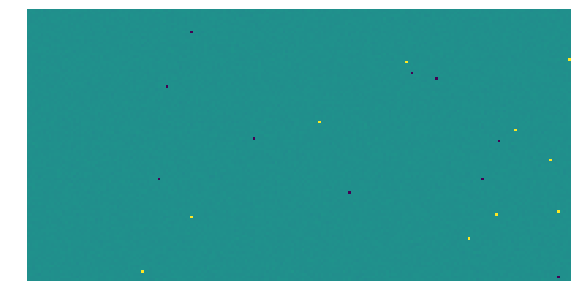

masked 20 / 20


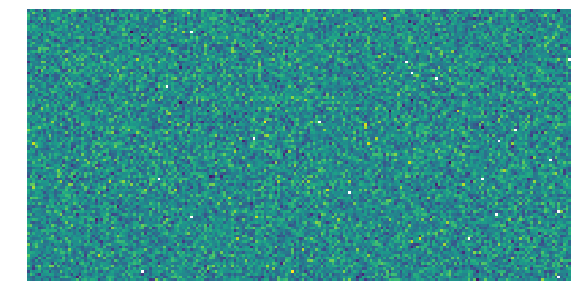

In [618]:
def test_masking(nx=200, ny=100, bias=1000., rms=10., nhot=10, ndead=10, seed=123, plot=True):
    rng = np.random.RandomState(seed)
    D = rng.normal(loc=bias, scale=rms, size = (ny, nx))
    ihot = rng.choice(D.size, nhot)
    idead = rng.choice(D.size, ndead)
    D.reshape(-1)[ihot] = bias + 100 * rms
    D.reshape(-1)[idead] = 0.
    D, W = prepare(D)
    
    if plot:
        plt.figure(figsize=(10, 5))
        plt.imshow(D)
        plt.gca().axis('off')
        plt.show()
    
    W, nmasked = mask_defects(D, W)
    print(f'masked {nmasked} / {nhot + ndead}')
    #D, W = mask_cosmics(D, W)
    
    if plot:
        D[W == 0] = np.nan
        plt.figure(figsize=(10, 5))
        plt.imshow(D)
        plt.gca().axis('off')
        plt.show()

test_masking()

In [606]:
%time test_masking(3072, 2048, nhot=0, ndead=0, plot=False)

masked 0 / 0
CPU times: user 3.98 s, sys: 192 ms, total: 4.18 s
Wall time: 858 ms


In [605]:
%time test_masking(3072, 2048, nhot=100, ndead=0, plot=False)

masked 100 / 100
CPU times: user 6.04 s, sys: 240 ms, total: 6.28 s
Wall time: 2.02 s


In [604]:
%time test_masking(3072, 2048, nhot=200, ndead=0, plot=False)

masked 200 / 200
CPU times: user 7.38 s, sys: 342 ms, total: 7.72 s
Wall time: 3.13 s


## Guide Camera Analysis

**TODO**:
 - Optionally decrease ivar in mask_defects() for pixels just below chisq_max.
 - Add variance proportional to smoothed (signal - clipped mean) in prepare (needs gain).
 - Estimate SNR for each stamp.

In [502]:
def draw_ellipse_cov(ax, center, cov, nsigmas=2, **ellipseopts):
    U, s, _ = np.linalg.svd(cov)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * nsigmas * np.sqrt(s.T)
    kwargs = dict(color='w', ls='-', lw=2, fill=False)
    kwargs.update(ellipseopts)
    ellipse = matplotlib.patches.Ellipse(center, width, height, angle, **kwargs)
    ax.add_artist(ellipse)

In [516]:
def plot_image(D, W, cov=None, center=[0, 0], ax=None):
    data = D.copy()
    data[W == 0] = np.nan
    ax = ax or plt.gca()
    I = ax.imshow(data, interpolation='none', origin='lower')
    #plt.colorbar(I, ax=ax)
    if cov is not None:
        ny, nx = data.shape
        center = np.asarray(center) + 0.5 * (np.array(data.shape) - 1)
        draw_ellipse_cov(ax, center, cov)
    ax.axis('off')

### SNR calculation

Given an assumed PSF profile $P_p$ with
$$
\sum_p P_p = 1 \; ,
$$
observed data $D_p$ and inverse variances $v_p$, we assume that the centroid is fixed so there is only one free parameter, the total flux $F$, and define the negative log likelihood:
$$
\ell \equiv \frac{1}{2} \sum_p \left( D_p - F P_p\right)^2 v_p \; .
$$
The maximum-likelihood solution occurs when:
$$
0 = \frac{\partial\ell}{\partial  F} = -\sum_p \left( D_p - F P_p\right) P_p v_p
= -\left( \sum_p D_p P_p v_p - F \sum_p P_p^2 v_p\right)
$$
at
$$
\hat{F} = \frac{\sum_p D_p P_p v_p}{\sum_p P_p^2 v_p} \; .
$$

Estimate the flux uncertainty as:
$$
\sigma_F^{-2} = \frac{\partial^2\ell}{\partial F^2}(\hat{F}) = \sum_p P_p^2 v_p
$$
then the corresponding signal-to-noise ratio is
$$
\nu \equiv \frac{\hat{F}}{\sigma_F} =
\left(\sum_p P_p^2 v_p\right)^{-1/2} \left(\sum_p D_p P_p v_p\right) \; .
$$
Note that this is exactly the significance $\varphi / \sqrt{\chi}$ found in Section 4 of Kaiser 2004.

In [704]:
class GuideCameraAnalysis(object):
    """
    """
    def __init__(self, stamp_size=55, pixel_size_um=9, plate_scales=(70., 76.), match_fwhm_arcsec=1.1):
        assert stamp_size % 2 == 1
        self.rsize = stamp_size // 2
        self.stamp_size = stamp_size
        # Build a nominal PSF model for detection matching.
        profile = functools.partial(moffat_profile, fwhm=match_fwhm_arcsec,
                                    sx=plate_scales[0] / pixel_size_um, sy=plate_scales[1] / pixel_size_um)
        self.PSF0 = make_template(stamp_size, profile, normalized=True)
        # Precompute PSF-weighted images for calculating second moments.
        dxy = np.arange(stamp_size) - 0.5 * (stamp_size - 1)
        self.xgrid, self.ygrid = np.meshgrid(dxy, dxy, sparse=False)
        self.PSFxx = self.PSF0 * self.xgrid ** 2
        self.PSFxy = self.PSF0 * self.xgrid * self.ygrid
        self.PSFyy = self.PSF0 * self.ygrid ** 2

    def detect_sources(self, D, W=None, nsrc_max=12, chisq_max=1e4,
                       size_min=3.5, ratio_min=0.7, snr_min=50., cdist_max=3.):
        D, W = prepare(D, W)
        W, nmasked = mask_defects(D, W, chisq_max, verbose=False)
        print('masked', nmasked, 'defects')
        ny, nx = D.shape
        h = self.rsize
        # Calculate the ivar-weighted image.
        WD = np.array(W * D, np.float32)
        # Convolve the image with each filter.
        CWD = Convolutions([WD], self.PSF0)
        WD = CWD.sources[0]
        WDf = CWD.convolved[0]
        CW = Convolutions([W], self.PSF0)
        Wf = CW.convolved[0]
        filtered = np.divide(WDf, Wf, out=np.zeros_like(W), where=Wf > 0)
        stamps = []
        params = []
        AX = Axes(nsrc_max)
        while len(stamps) < nsrc_max:
            ax = AX.axes[len(stamps)]

            # Find the next largest filtered pixel.
            iy, ix = np.unravel_index(np.argmax(filtered), (ny, nx))
            xlo, ylo = max(0, ix - h), max(0, iy - h)
            xhi, yhi = min(nx, ix + h + 1), min(ny, iy + h + 1)

            # Redo the filtering with the data in this stamp set to zero (for next time).
            changed = CWD.set_source(slice(ylo, yhi), slice(xlo, xhi), 0)
            filtered[changed] = 0
            filtered[changed] = np.divide(
                WDf[changed], Wf[changed], out=filtered[changed], where=Wf[changed] > 0)
                        
            # Ignore stamps that are not fully contained.
            if ix < h or iy < h or ix + h >= nx or iy + h >= ny:
                continue
            
            stamp = D[ylo:yhi, xlo:xhi].copy()
            ivar = W[ylo:yhi, xlo:xhi].copy()
            
            #plot_image(stamp, ivar, ax=ax)
            
            # Do a second pass of defect masking with tighter cuts.
            ivar, nmasked = mask_defects(stamp, ivar, 100., verbose=False)
            
            # Calculate the stamp's centroid (w/o centered PSF weights)
            clipped = np.maximum(0., stamp)
            M0 = np.sum(clipped * ivar)
            Mx = np.sum(self.xgrid * clipped * ivar) / M0
            My = np.sum(self.ygrid * clipped * ivar) / M0
            
            # Calculate the centroid distance from the stamp center.
            cdist = np.sqrt(Mx ** 2 + My ** 2)

            # Ignore stamps whose centroid is not centered, which probably indicates
            # we have found the wing of a previously found bright star.
            if cdist > cdist_max:
                continue

            # Calculate the stamp's template-weighted second moments
            # relative to the stamp center.
            M0 = np.sum(self.PSF0 * clipped * ivar)
            Mxx = np.sum(self.PSFxx * clipped * ivar) / M0
            Mxy = np.sum(self.PSFxy * clipped * ivar) / M0
            Myy = np.sum(self.PSFyy * clipped * ivar) / M0
            
            # Calculate the determinant size.
            det = Mxx * Myy - Mxy ** 2
            size = det ** 0.25 if det > 0 else 0.
            
            # Calculate the minor / major axis ratio.
            trace = Mxx + Myy
            diff = np.sqrt((Mxx - Myy) ** 2 + 4 * Mxy ** 2)
            major = np.sqrt(0.5 * (trace + diff))
            minor = np.sqrt(0.5 * (trace - diff))
            ratio = minor / major
            #print(trace, diff, major, minor, ratio)
            
            # Calculate the SNR2 as the weighted mean of the pixel SNR2 value.
            ##SNR = np.sqrt(max(0., np.sum(self.PSF0 * ivar * stamp ** 2)))
            SNR = np.sum(stamp * self.PSF0 * ivar) / np.sqrt(np.sum(self.PSF0 ** 2 * ivar))

            # Is this stamp sufficiently PSF like?
            keep = (SNR > snr_min) and (size > size_min) and (ratio > ratio_min)

            plot_image(stamp, ivar, cov=[[Mxx, Mxy], [Mxy, Myy]], ax=ax)
            
            label = f'$\\nu$ {SNR:.1f} $\\sigma$ {size:.1f} $r$ {ratio:.2f}'
            ax.text(0.5, 0.95, label, horizontalalignment='center', verticalalignment='center',
                    fontsize=22, fontweight='bold', color='w' if keep else 'k', transform=ax.transAxes)
            
            stamps.append((stamp, ivar))
            params.append((SNR, size, ratio))

GCA = GuideCameraAnalysis(stamp_size=75)

masked 334 defects
CPU times: user 10.7 s, sys: 342 ms, total: 11 s
Wall time: 3.77 s


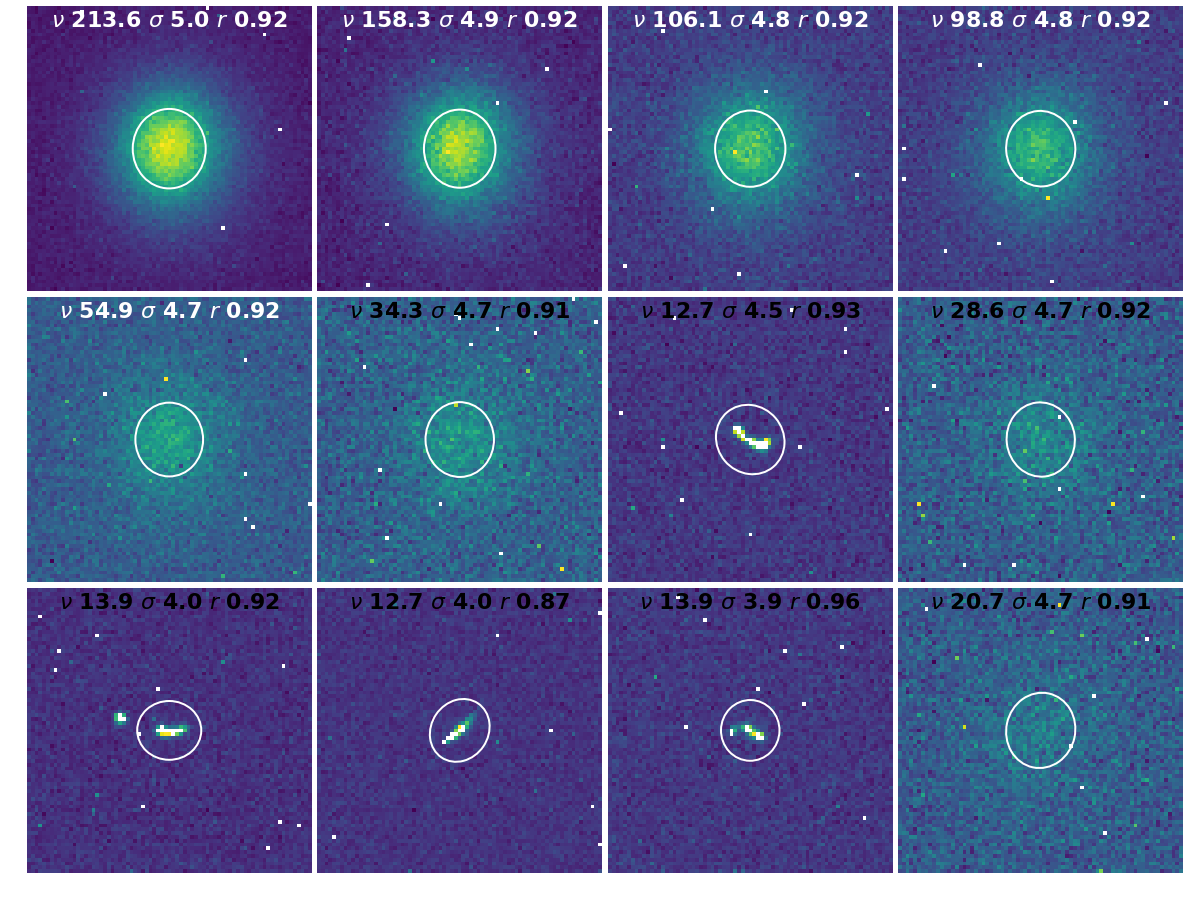

In [695]:
%time GCA.detect_sources(images['CIE'])

masked 313 defects
CPU times: user 10.2 s, sys: 312 ms, total: 10.5 s
Wall time: 3.55 s


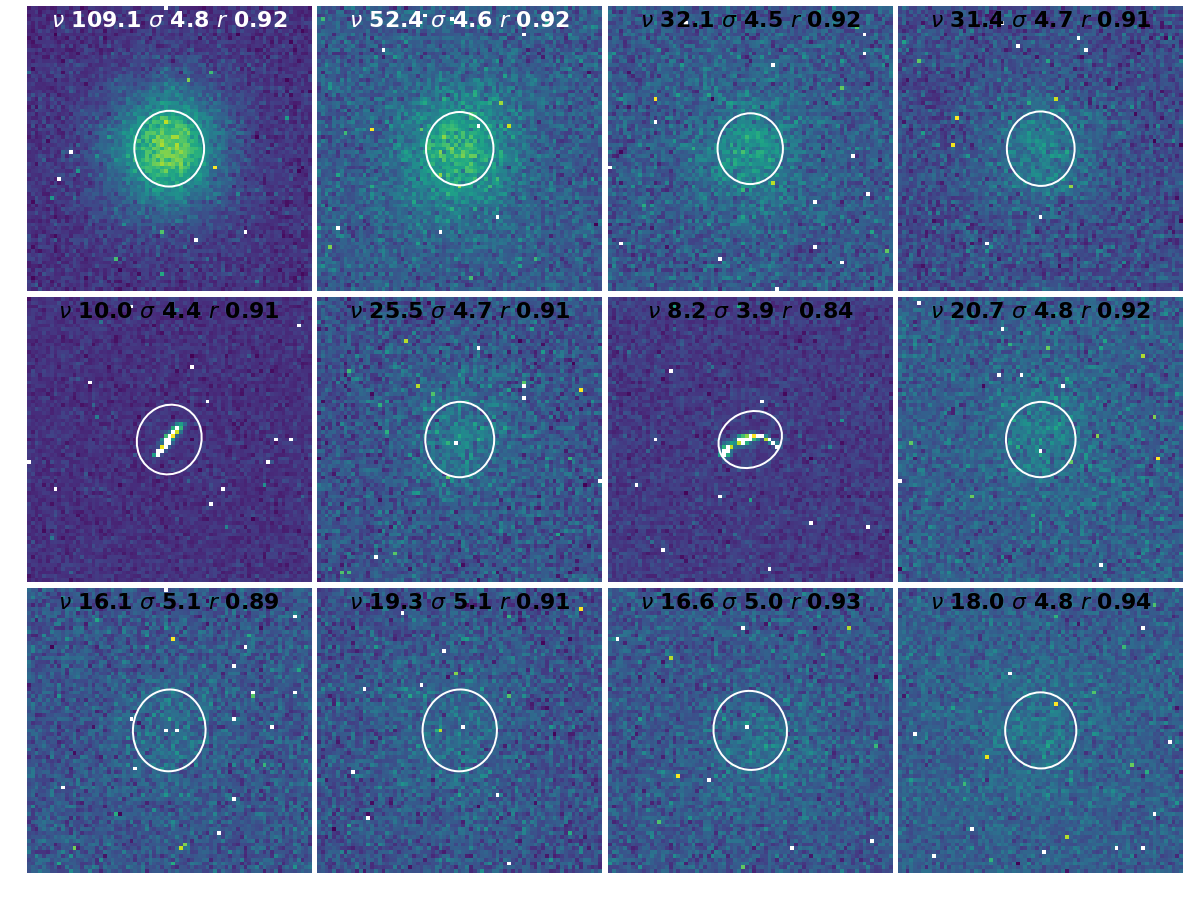

In [696]:
%time GCA.detect_sources(images['CIW'])

masked 335 defects
CPU times: user 11.5 s, sys: 326 ms, total: 11.8 s
Wall time: 3.89 s


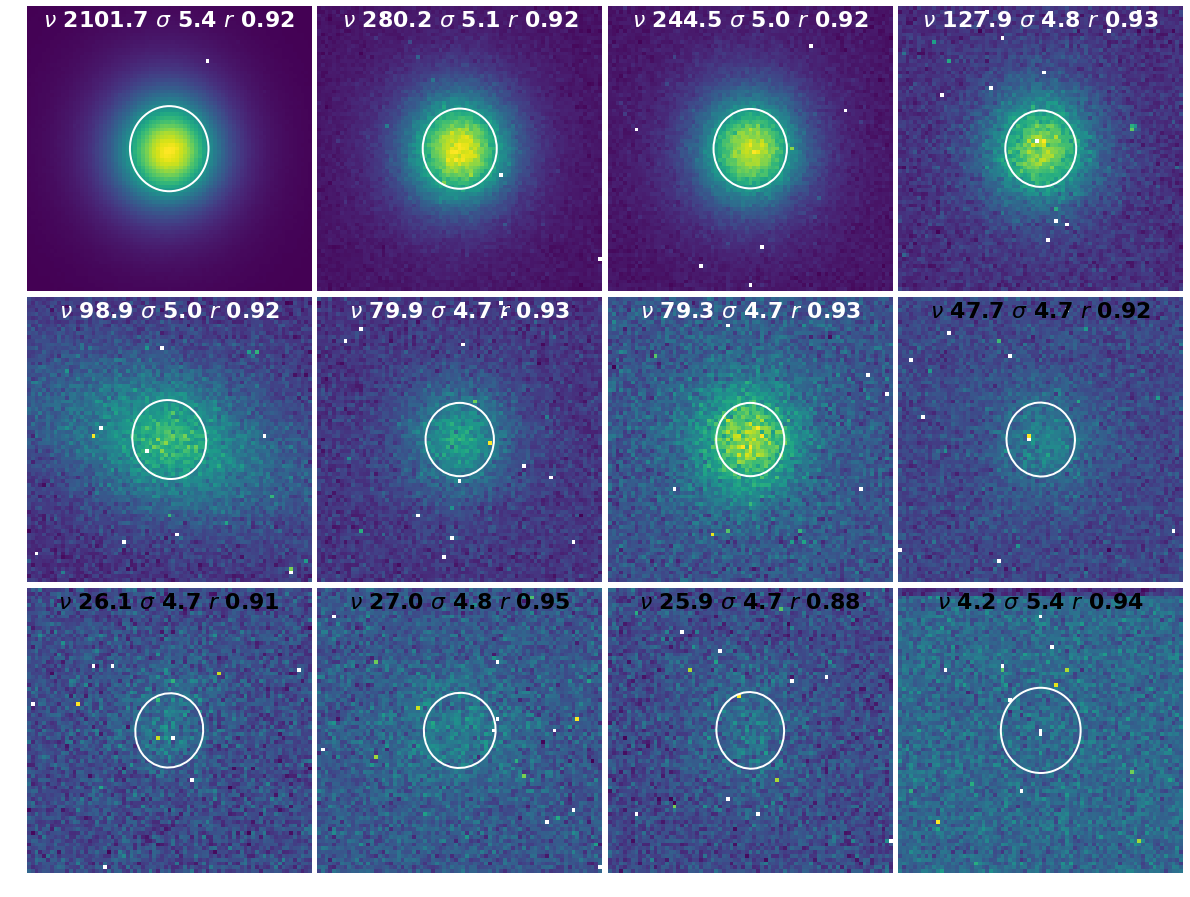

In [697]:
%time GCA.detect_sources(images['CIN'])

masked 354 defects
CPU times: user 10.9 s, sys: 350 ms, total: 11.2 s
Wall time: 4 s


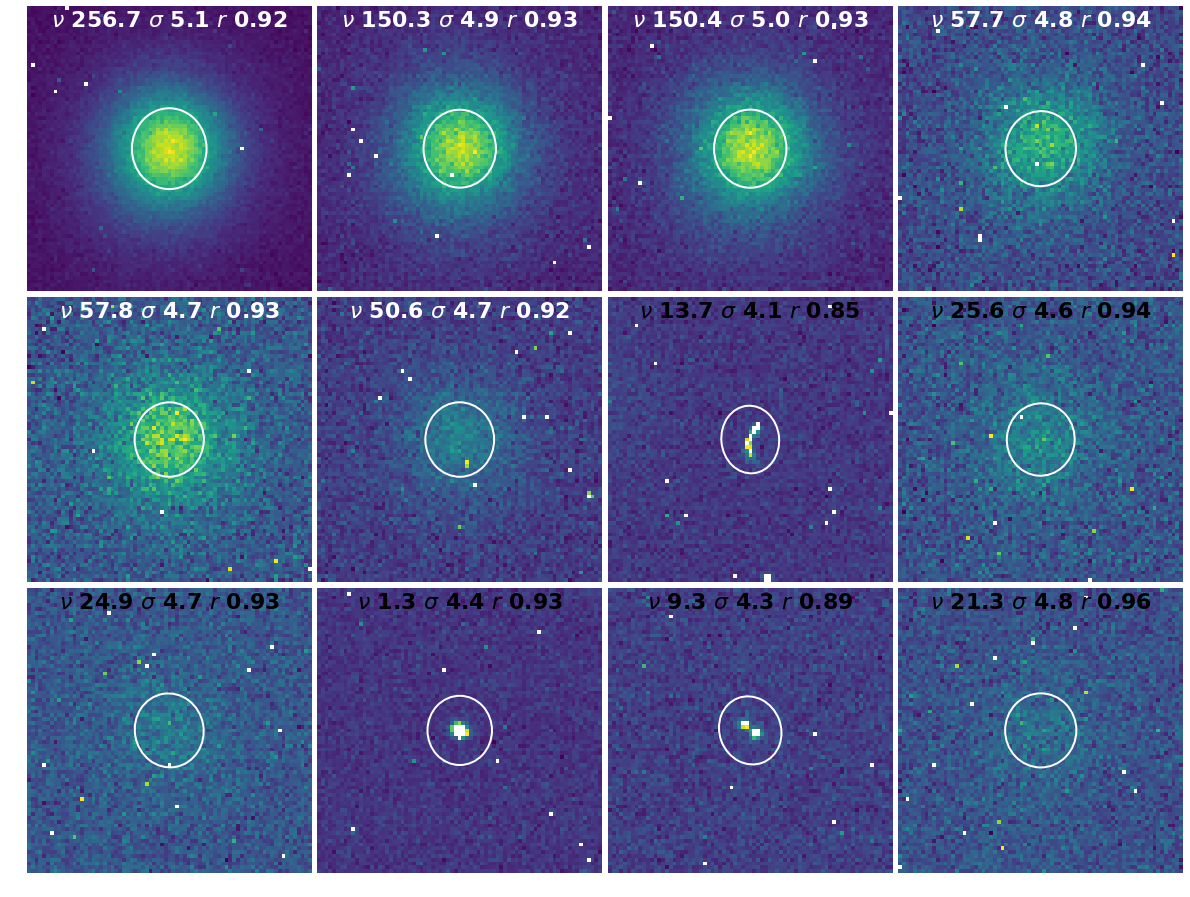

In [698]:
%time GCA.detect_sources(images['CIS'])

masked 351 defects
CPU times: user 10.7 s, sys: 349 ms, total: 11.1 s
Wall time: 3.9 s


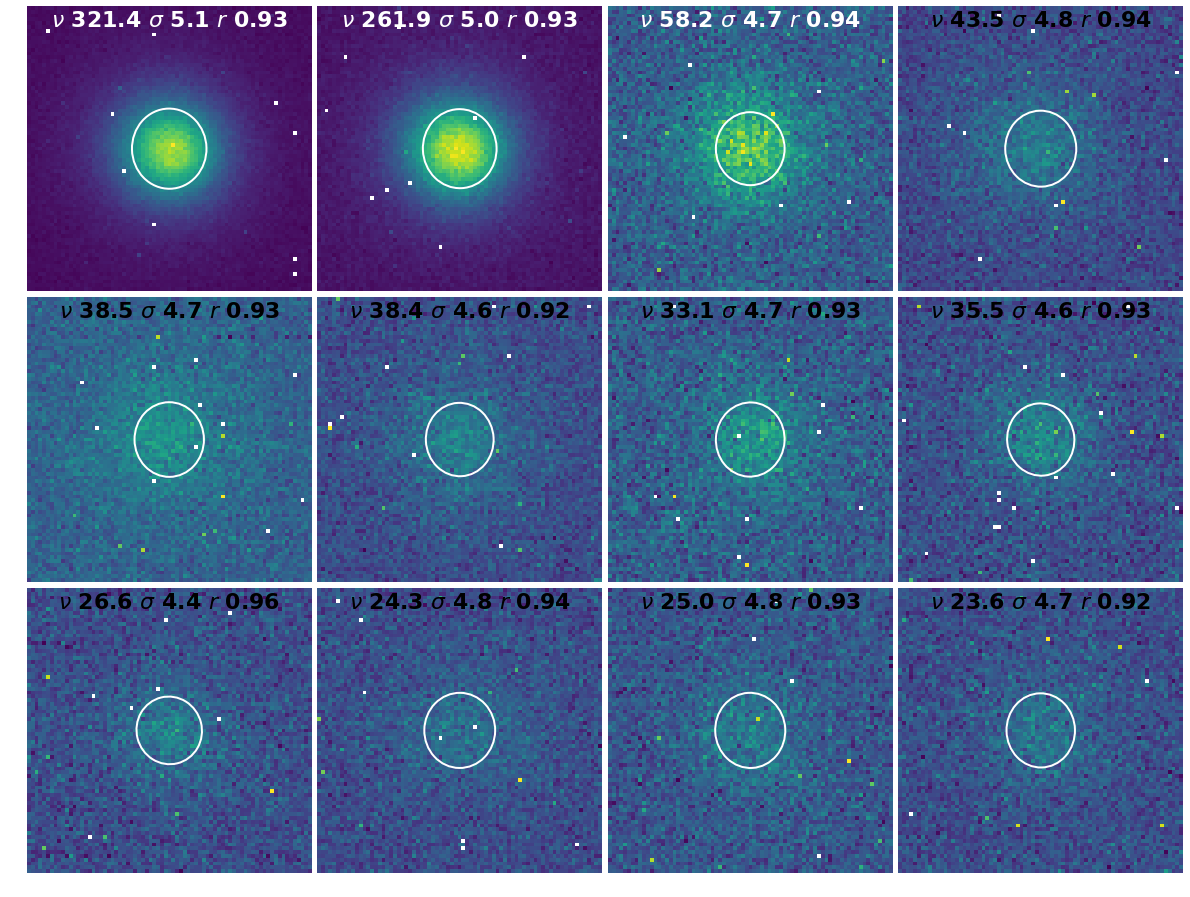

In [699]:
%time GCA.detect_sources(images['CIC'])